## 요리 사진 판정 방법
1. 사진에 어떤 요리가 있는지 판정
2. 판정한 요리의 칼로리를 출력

### 머신러닝을 할 때 가장 어려운 것은 데이터 수집
- 각 요리에 대해 100장씩 수집
- [Flicker API 페이지](https://www.flickr.com/services/api/) - 회원가입/로그인 - API 제작 - 비상업용 키 신청 - 키, 암호 발급
- `pip install flickrapi`

### 이미지 내려받기
- 75x75 픽셀의 정사각형 이미지 300개
- 한 번에 대량의 이미지를 내려받으면 서버에 부하가 걸릴 수 있으므로 1초에 한 번 수행
- 최대 300개의 이미지 url 제공

In [ ]:
from flickrapi import FlickrAPI
from urllib.request import urlretrieve
from pprint import pprint
import os, time, sys

# API 키 지정
from pathlib import Path
import os
import json

secret_file = 'secrets.json'
with open(secret_file) as f:
    secrets = json.loads(f.read())

def get_secret(setting, secrets=secrets):
    try:
        return secrets[setting]
    except :
        print('error')
        
key = get_secret("key")
secret = get_secret("secret")
wait_time = 1 # 대기 시간(초)

# 키워드와 디렉터리 이름을 지정해서 다운로드하기
def main():
    go_download('초밥', 'sushi')
    go_download('샐러드', 'salad')
    go_download('마파두부', 'tofu')

# Flickr API로 사진 검색
def go_download(keyword, dir):
    # 저장 경로 지정
    savedir = '../datasets/image/' + dir
    if not os.path.exists(savedir):
        os.makedirs(savedir)
        
    # API를 사용해서 다운로드하기
    flickr = FlickrAPI(key, secret, format='parsed-json')
    res = flickr.photos.search(
        text = keyword,      # 키워드
        per_page = 300,      # 검색할 개수
        media = 'photos',    # 사진 검색
        sort = 'relevance',  # 키워드 관련도 순서
        safe_search = 1,     # 안전 검색
        extras = 'url_q, license')
    
    # 결과 확인하기
    photos = res['photos']
    pprint(photos)
    try:
        # 1장씩 다운로드하기
        for i, photo in enumerate(photos['photo']):
            url_q = photo['url_q']
            filepath = savedir + '/' + photo['id'] + '.jpg'
            if os.path.exists(filepath): continue
            print(str(i+1) + ":download=", url_q)
            urlretrieve(url_q, filepath)
            time.sleep(wait_time)
    except:
        import traceback
        traceback.print_exc()

if __name__ == '__main__':
    main()

### 클리닝 - 관계없는 사진 제거하기
- 관계 없는 사진 직접 제거
- 제대로 하지 않으면 정답률이 제대로 나오지 않으므로 반드시 진행하여야 함

### 디렉터리 내부의 이미지를 NumPy 형식으로 합치기
- RGB로 변환, 0~1 사이의 수로 변환

In [24]:
import numpy as np
from PIL import Image
import os, glob, random

outfile = '../datasets/image/photos.npz'
max_photo = 100
photo_size = 32 # 이미지 크기
x = []
y = []

def main():
    glob_files('../datasets/image/sushi', 0)
    glob_files('../datasets/image/salad', 1)
    glob_files('../datasets/image/tofu', 2)
    
    np.savez(outfile, x=x, y=y)
    print('저장했습니다.:' + outfile, len(x))
    
# path 내부의 이미지 읽어들이기
def glob_files(path, label):
    files = glob.glob(path+'/*.jpg')
    random.shuffle(files)
    
    num = 0
    for f in files:
        if num >= max_photo:break
        num += 1
        
        # 이미지 파일 읽어들이기
        img = Image.open(f)
        img = img.convert("RGB")
        img = img.resize((photo_size, photo_size))
        img = np.asarray(img)
        x.append(img)
        y.append(label)
        
if __name__ == '__main__':
    main()

저장했습니다.:../datasets/image/photos.npz 263


#### 확인

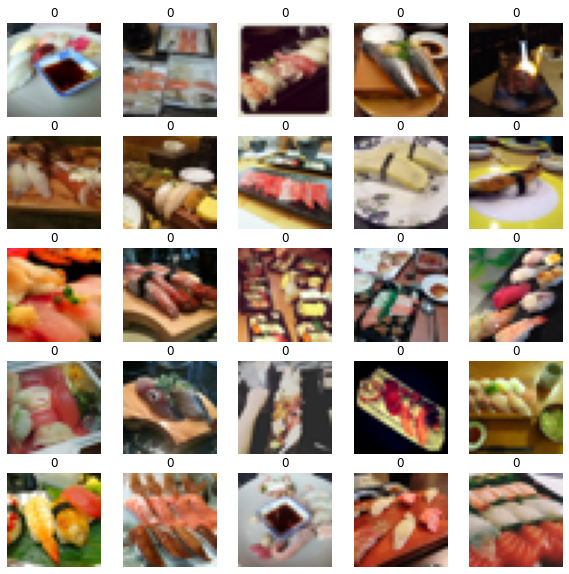

In [2]:
import matplotlib.pyplot as plt
import numpy as np
# 사진 데이터
photos = np.load('../datasets/image/photos.npz')
x = photos['x']
y = photos['y']

# 시작 인덱스
idx = 0
# 출력
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.axis('off')
    plt.title(y[i+idx])
    plt.imshow(x[i+idx])
plt.show()

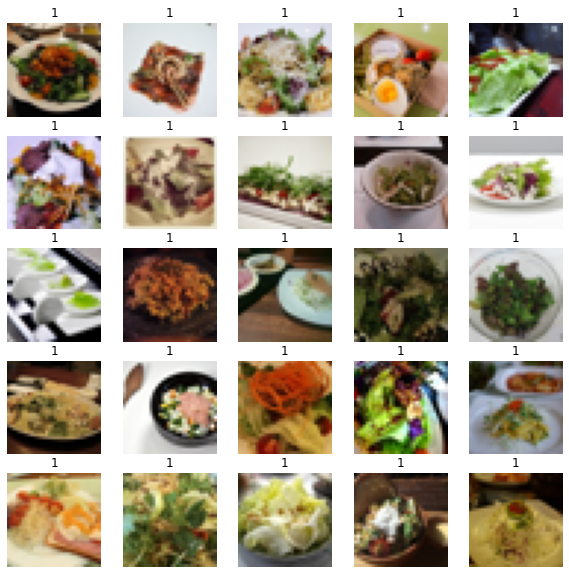

In [3]:
idx = 100

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.axis('off')
    plt.title(y[i+idx])
    plt.imshow(x[i+idx])
plt.show()

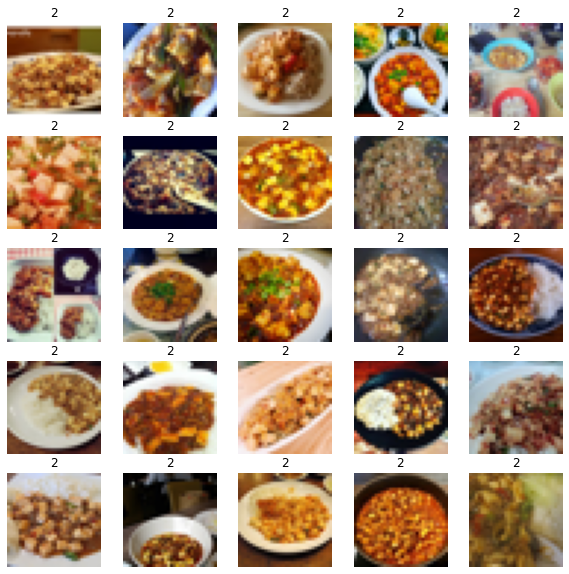

In [4]:
idx = 200

plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.axis('off')
    plt.title(y[i+idx])
    plt.imshow(x[i+idx])
plt.show()

### CNN으로 학습시키기
- 결과가 좋다고 알려진 CNN 모델 이용
- `cnn_model.py`

```python
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import RMSprop

# CNN 모델 정의
def def_model(in_shape, nb_classes):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=in_shape))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(512, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(nb_classes, activation='softmax'))
    return model

# 컴파일하고 모델 반환
def get_model(in_shape, nb_classes):
    model = def_model(in_shape, nb_classes)
    model.compile(loss='categorical_crossentropy',
                 optimizer=RMSprop(), metrics=['accuracy'])
    return model
```


In [5]:
import cnn_model
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

# 입출력 지정
im_rows = 32
im_cols = 32
im_color = 3
in_shape = (im_rows, im_cols, im_color)
nb_classes = 3

# 사진 데이터
photos = np.load('../datasets/image/photos.npz')
x = photos['x']
y = photos['y']

# 3차원 배열로 변환
x = x.reshape(-1, im_rows, im_cols, im_color)
x = x.astype('float32') / 255

# 레이블 OHE 변환
y = keras.utils.to_categorical(y.astype('int32'), nb_classes)

# 분리
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [6]:
# CNN 모델 생성
model = cnn_model.get_model(in_shape, nb_classes)

In [7]:
# 학습 실행
hist = model.fit(x_train, y_train, batch_size=32,
                epochs=20, verbose=1, validation_data=(x_test, y_test))

Epoch 1/20
7/7 [==============================] - 3s 68ms/step - loss: 1.1206 - accuracy: 0.3810 - val_loss: 1.0933 - val_accuracy: 0.3019
Epoch 2/20
7/7 [==============================] - 0s 10ms/step - loss: 1.0960 - accuracy: 0.4000 - val_loss: 1.0726 - val_accuracy: 0.3774
Epoch 3/20
7/7 [==============================] - 0s 9ms/step - loss: 1.0603 - accuracy: 0.4571 - val_loss: 1.0549 - val_accuracy: 0.4717
Epoch 4/20
7/7 [==============================] - 0s 10ms/step - loss: 1.0356 - accuracy: 0.4286 - val_loss: 1.0537 - val_accuracy: 0.4528
Epoch 5/20
7/7 [==============================] - 0s 10ms/step - loss: 1.0167 - accuracy: 0.4857 - val_loss: 1.1321 - val_accuracy: 0.3585
Epoch 6/20
7/7 [==============================] - 0s 9ms/step - loss: 1.0679 - accuracy: 0.5143 - val_loss: 1.0469 - val_accuracy: 0.4340
Epoch 7/20
7/7 [==============================] - 0s 10ms/step - loss: 0.9562 - accuracy: 0.5524 - val_loss: 1.1104 - val_accuracy: 0.3585
Epoch 8/20
7/7 [=============

In [8]:
# 모델 평가
score = model.evaluate(x_test, y_test, verbose=1)
print('정답률 :', score[1], '손실률 :', score[0])

2/2 [==============================] - 0s 4ms/step - loss: 1.5701 - accuracy: 0.4151
정답률 : 0.4150943458080292 손실률 : 1.5700654983520508


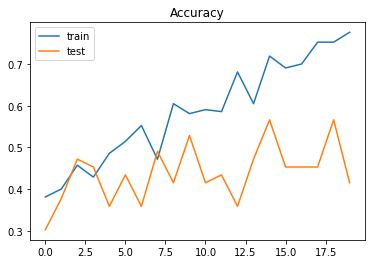

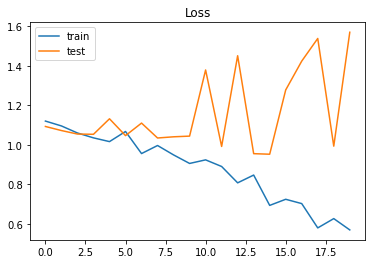

In [9]:
# 시각화
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [10]:
model.save_weights('../models/photos-model-light.hdf5')

### 학습 데이터의 수량 늘리기
- 컴퓨터는 사진이 조금만 회전되어도 다른 사진으로 인식

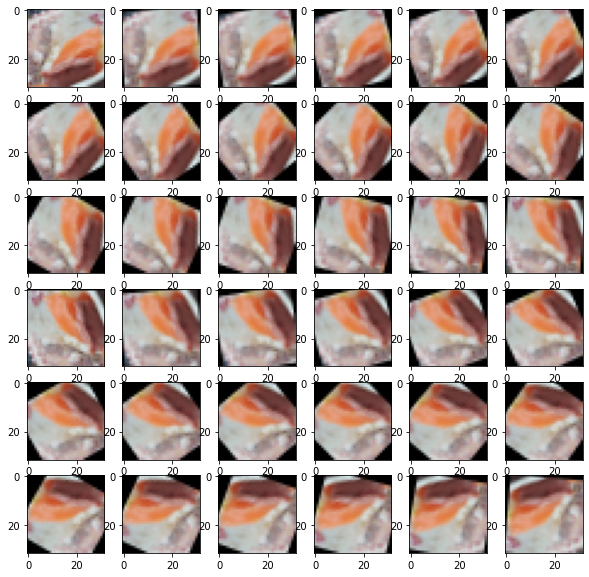

In [27]:
import matplotlib.pyplot as plt
import cv2

photos = np.load('../datasets/image/photos.npz')
x = photos['x']
img = x[42] # 임의의 사진 하나 선택

plt.figure(figsize=(10, 10))
for i in range(36):
    plt.subplot(6, 6, i+1)
    # 회전
    center = (16, 16) # 회전 중심
    angle = i * 5     # 각도 지정
    scale = 1.0       # 확대
    mtx = cv2.getRotationMatrix2D(center, angle, scale)
    img2 = cv2.warpAffine(img, mtx, (32, 32))
    
    # 화면에 출력
    plt.imshow(img2)
plt.show()

### 수량을 늘리고 학습하기

In [28]:
import cnn_model
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

# 입출력 지정
im_rows = 32
im_cols = 32
im_color = 3
in_shape = (im_rows, im_cols, im_color)
nb_classes = 3

# 사진 데이터
photos = np.load('../datasets/image/photos.npz')
x = photos['x']
y = photos['y']

# 3차원 배열로 변환
x = x.reshape(-1, im_rows, im_cols, im_color)
x = x.astype('float32') / 255

# 레이블 OHE 변환
y = keras.utils.to_categorical(y.astype('int32'), nb_classes)

# 분리
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

# 학습 전용 데이터 수 늘리기
x_new = []
y_new = []

for i, xi in enumerate(x_train):
    yi = y_train[i]
    for ang in range(-30, 30, 5):
        # 회전
        center = (16, 16) # 회전 중심
        mtx = cv2.getRotationMatrix2D(center, ang, 1.0)
        xi2 = cv2.warpAffine(xi, mtx, (32, 32))
        x_new.append(xi2)
        y_new.append(yi)
        
        # 좌우 반전
        xi3 = cv2.flip(xi2, 1)
        x_new.append(xi3)
        y_new.append(yi)
        
        
# 이미지를 늘린 데이터를 학습 데이터로 사용
print('수량을 늘리기 전 :', len(y_train))
x_train = np.array(x_new)
y_train = np.array(y_new)
print('수량을 늘린 후 :', len(y_train))

수량을 늘리기 전 : 210
수량을 늘린 후 : 5040


In [29]:
# CNN 모델 생성
model = cnn_model.get_model(in_shape, nb_classes)

In [30]:
# 학습 실행
hist = model.fit(x_train, y_train, batch_size=32,
                epochs=20, verbose=1, validation_data=(x_test, y_test))

Epoch 1/20
158/158 [==============================] - 2s 9ms/step - loss: 1.0012 - accuracy: 0.5093 - val_loss: 0.9975 - val_accuracy: 0.5472
Epoch 2/20
158/158 [==============================] - 1s 7ms/step - loss: 0.7461 - accuracy: 0.6685 - val_loss: 0.9225 - val_accuracy: 0.6226
Epoch 3/20
158/158 [==============================] - 1s 7ms/step - loss: 0.5331 - accuracy: 0.7764 - val_loss: 1.2002 - val_accuracy: 0.6226
Epoch 4/20
158/158 [==============================] - 1s 7ms/step - loss: 0.3637 - accuracy: 0.8597 - val_loss: 1.6391 - val_accuracy: 0.6792
Epoch 5/20
158/158 [==============================] - 1s 7ms/step - loss: 0.2577 - accuracy: 0.9099 - val_loss: 1.5513 - val_accuracy: 0.6981
Epoch 6/20
158/158 [==============================] - 1s 7ms/step - loss: 0.1827 - accuracy: 0.9435 - val_loss: 3.3718 - val_accuracy: 0.6604
Epoch 7/20
158/158 [==============================] - 1s 7ms/step - loss: 0.1550 - accuracy: 0.9482 - val_loss: 2.0678 - val_accuracy: 0.6981
Epoch 

In [31]:
# 모델 평가
score = model.evaluate(x_test, y_test, verbose=1)
print('정답률 :', score[1], '손실률 :', score[0])

2/2 [==============================] - 0s 4ms/step - loss: 5.3903 - accuracy: 0.6415
정답률 : 0.6415094137191772 손실률 : 5.3903117179870605


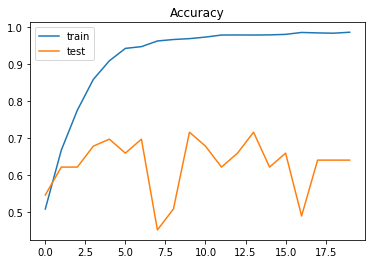

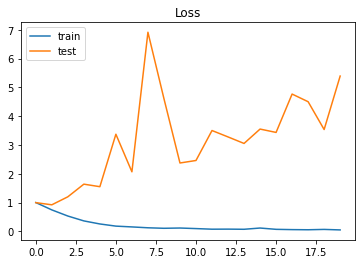

In [32]:
# 시각화
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [33]:
model.save_weights('../models/photos-model-light.hdf5')

## 테스트

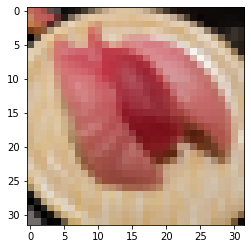

이 사진은 초밥 로(으로), 칼로리는 588 kcal입니다.
가능성은 99 %입니다.


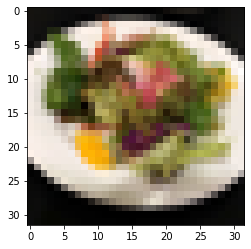

이 사진은 샐러드 로(으로), 칼로리는 118 kcal입니다.
가능성은 100 %입니다.


In [34]:
import cnn_model
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

im_rows = 32
im_cols = 32
im_color = 3
in_shape = (im_rows, im_cols, im_color)
nb_classes = 3

LABELS = ['초밥', '샐러드', '마파두부']
CALORIES = [588, 118, 648]

# CNN 모델 읽어들이기
model = cnn_model.get_model(in_shape, nb_classes)
model.load_weights('../models/photos-model-light.hdf5')

def check_photo(path):
    # 이미지 읽어 들이기
    img = Image.open(path)
    img = img.convert('RGB')
    img = img.resize((im_cols, im_rows))
    plt.imshow(img)
    plt.show()
    
    # 데이터로 변환
    x = np.asarray(img)
    x = x.reshape(-1, im_rows, im_cols, im_color) / 255
    
    # 예측
    pre = model.predict([x])[0]
    idx = pre.argmax()
    per = int(pre[idx] * 100)
    return idx, per

def check_photo_str(path):
    idx, per = check_photo(path)
    # 응답하기
    print('이 사진은', LABELS[idx], '로(으로), 칼로리는', CALORIES[idx], 'kcal입니다.')
    print('가능성은', per, '%입니다.')
    
if __name__ == '__main__':
    check_photo_str('../datasets/test-sushi.jpg')
    check_photo_str('../datasets/test-salad.jpg')